<div style="text-align:center">
  <h1>Assignment .....</h1>
  <h3>Yannick van Etten (703308)</h3>
  <h3>Leonard Loechelt ()</h3>
  <h3>Master Econometrics and Operations Research</h3>
</div>

<div style="text-align:center">
  <h4>Introduction</h4>
</div>

Small intro regarding project

In [1]:
import numpy.random as rnd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

<div style="text-align:center">
  <h4>Timeseries simulation</h4>
</div>

In [2]:
def simulate_data(phi1, phi2, theta1, alpha, sigma, alpha_crisis, sigma_crisis, T, crisis_start, crisis_end):
    #np.random.seed(42)

    y = np.zeros(T)
    eps = np.random.normal(0, sigma, T)
    eps_lag = 0

    # Simulate ARMA(2,1) with structural break
    for t in range(2, T):
        if crisis_start <= t <= crisis_end:
            current_alpha = alpha_crisis
            current_sigma = sigma_crisis
            eps[t] = np.random.normal(0, current_sigma)
        else:
            current_alpha = alpha
            current_sigma = sigma
            eps[t] = np.random.normal(0, current_sigma)
        
        y[t] = (current_alpha + phi1 * y[t-1] + phi2 * y[t-2] + 
                theta1 * eps_lag + eps[t])
        eps_lag = eps[t]
    return y 

def plot_gdp(y, crisis_start, crisis_end):
    plt.figure(figsize=(10,4))
    plt.plot(y, label="Simulated GDP-like Series")
    plt.axvspan(crisis_start, crisis_end, color='red', alpha=0.2, label='Crisis Period')
    plt.title("Simulated Time Series with Structural Break")
    plt.legend()
    plt.tight_layout()
    plt.show()

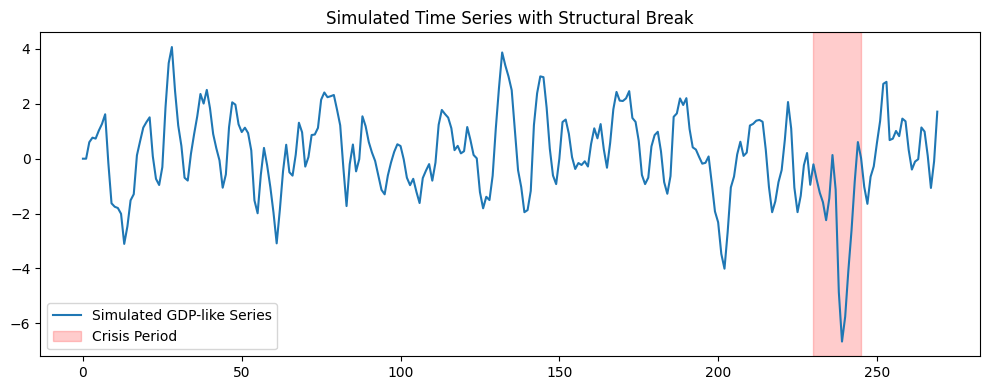

In [29]:
np.random.seed(101)
phi1, phi2 = 1, -0.3
theta1 = 0.3
alpha = 0.1
sigma = 0.6

# Parameters during crisis
alpha_crisis = -0.7
sigma_crisis = 1

# TS in order
T = 270
crisis_start, crisis_end = 230, 245
y = simulate_data(phi1, phi2, theta1, alpha, sigma, alpha_crisis, sigma_crisis, T, crisis_start, crisis_end)
plot_gdp(y, crisis_start, crisis_end)

<div style="text-align:center">
  <h4>In sample estimation</h4>
</div>

In [30]:
def estimate_ar2(y, t_start, t_end):
    Y = y[t_start:t_end + 1]  # y_t
    X = np.column_stack((
        np.ones(t_end - t_start + 1),
        y[t_start - 1:t_end],      # y_{t-1}
        y[t_start - 2:t_end - 1]   # y_{t-2}
    ))    
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
    alpha, phi1, phi2 = beta_hat
    return alpha, phi1, phi2

def forecast_adaptive(y, t_start, t_end, theta):
    preds = theta * y[t_start - 1:t_end] + (1 - theta) * y[t_start - 2:t_end - 1]
    true_vals = y[t_start:t_end + 1]
    error = true_vals - preds
    return preds, error

def forecast_trend(y, t_start, t_end, gamma):
    delta = y[t_start - 1:t_end] - y[t_start - 2:t_end - 1]
    preds = y[t_start - 1:t_end] + gamma * delta
    true_vals = y[t_start:t_end + 1]
    error = true_vals - preds 
    return preds, error

def forecast_anchor(y, t_start, t_end, lamb, bar_y):
    preds = lamb * bar_y + (1 - lamb) * y[t_start - 1:t_end]
    true_vals = y[t_start:t_end + 1]
    error = true_vals - preds 
    return preds, error

def forecast_ectrie(y, t_start, t_end, alpha, phi1, phi2):
    preds = alpha + phi1 * y[t_start - 1:t_end] + phi2 * y[t_start - 2:t_end - 1]
    true_vals = y[t_start:t_end + 1]
    error = true_vals - preds
    return preds, error

def estimate_theta_adaptive(y, t_start, t_end):
    def mse(theta):
        preds, error = forecast_adaptive(y, t_start, t_end, theta)
        return np.mean((error) ** 2)
    result = minimize(mse, x0=[0.5], bounds=[(0, 2)])
    return result.x[0]

def estimate_gamma_trend(y, t_start, t_end):
    def mse(gamma):
        preds, error = forecast_trend(y, t_start, t_end, gamma)
        return np.mean((error) ** 2)
    result = minimize(mse, x0=[0.5], bounds=[(-2, 2)])
    return result.x[0]

def estimate_lambda_anchor(y, t_start, t_end):
    bar_y = np.mean(y[t_start - 2:t_end + 1]) 
    def mse(lamb):
        preds, error = forecast_anchor(y, t_start, t_end, lamb, bar_y)
        return np.mean((error) ** 2)
    result = minimize(mse, x0=[0.5], bounds=[(0, 1)])
    return result.x[0]

def weighted_abm_forecast(y_true, y_adapt, y_trend, y_anchor, beta, delta, window=10):
    n = len(y_true)
    combined_forecast = np.zeros(n)
    weights_over_time = np.zeros((n, 3))
    weights_over_time[0, :] = 1/3
    
    for t in range(1, n):
        # Compute rolling MSE for each heuristic over the last 'window' observations ending at t-1
        start_idx = max(0, t - window)
        mse_adapt = np.mean((y_true[start_idx:t] - y_adapt[start_idx:t])**2)
        mse_trend = np.mean((y_true[start_idx:t] - y_trend[start_idx:t])**2)
        mse_anchor = np.mean((y_true[start_idx:t] - y_anchor[start_idx:t])**2)
        mses = np.array([mse_adapt, mse_trend, mse_anchor])
        
        exp_weights = np.exp(-beta * mses)
        dc_weights = exp_weights / np.sum(exp_weights)
        
        weights_over_time[t, :] = (1 - delta) * dc_weights + delta * weights_over_time[t - 1, :]        
        weights_over_time[t, :] /= np.sum(weights_over_time[t, :])
    
    for t in range(n):
        combined_forecast[t] = (
            weights_over_time[t, 0] * y_adapt[t] +
            weights_over_time[t, 1] * y_trend[t] +
            weights_over_time[t, 2] * y_anchor[t]
        )
    return combined_forecast, weights_over_time 


def objective_beta_delta(params, y_true, y_adaptive, y_trend, y_anchor, window):
    beta, delta = params
    if beta < 0 or not (0 <= delta <= 1):
        return 1e10  # penalty for invalid params
    combined, _ = weighted_abm_forecast(y_true, y_adaptive, y_trend, y_anchor, beta, delta, window)
    rmsfe = np.sqrt(np.mean((y_true - combined) ** 2))
    return rmsfe

def forecasts(y, t_out_start, t_start, t_end, alpha_hat, phi1_hat, phi2_hat, theta_hat, gamma_hat, lambda_hat, beta_hat, delta_hat):
    n_forecast = len(y)-1-t_out_start 
    y_hat_ectrie = np.zeros(n_forecast)
    y_hat_adaptive = np.zeros(n_forecast)
    y_hat_trend = np.zeros(n_forecast)
    y_hat_anchor = np.zeros(n_forecast)

    bar_y = np.mean(y[t_start:t_end + 1]) 
    for i, t in enumerate(range(t_out_start, len(y) - 1)):
        y_hat_ectrie[i] = alpha_hat + phi1_hat * y[t] + phi2_hat * y[t - 1]
        y_hat_adaptive[i] = theta_hat * y[t] + (1 - theta_hat) * y[t - 1]
        y_hat_trend[i] = y[t] + gamma_hat * (y[t] - y[t - 1])
        y_hat_anchor[i] = lambda_hat * bar_y + (1 - lambda_hat) * y[t]
    y_true_out = y[t_out_start + 1: t_out_start + 1 + n_forecast]

    y_hat_abm, weights_over_time = weighted_abm_forecast(y_true_out, y_hat_adaptive, y_hat_trend, y_hat_anchor, beta_hat, delta_hat, window=10)
    return y_hat_ectrie, y_hat_adaptive, y_hat_trend, y_hat_anchor, y_hat_abm, y_true_out

def calc_msfe(forecast, true_values):
    return np.mean((true_values - forecast) ** 2)

def calc_weight_forecast_comb(y_insample, y_hat_ectrie, y_hat_abm):
    err_abm = y_insample - y_hat_abm
    err_ectrie = y_insample - y_hat_ectrie

    var_abm = np.var(err_abm, ddof=1)
    var_ectrie = np.var(err_ectrie, ddof=1)
    cov_abm_ectrie = np.cov(err_abm, err_ectrie, ddof=1)[0,1]

    w_star = (var_ectrie - cov_abm_ectrie) / (var_abm + var_ectrie - 2 * cov_abm_ectrie)
    w_star = np.clip(w_star, 0, 1)
    return w_star

In [31]:
# Now insample estimation of parameters
t_start, t_end = 2, 180
alpha_hat, phi1_hat, phi2_hat = estimate_ar2(y, t_start, t_end)
print(f"AR(2): alpha = {alpha_hat:.4f}, phi1 = {phi1_hat:.4f}, phi2 = {phi2_hat:.4f}")
theta_hat = estimate_theta_adaptive(y, t_start, t_end)
gamma_hat = estimate_gamma_trend(y, t_start, t_end)
lambda_hat = estimate_lambda_anchor(y, t_start, t_end)
print(f"ABM: theta = {theta_hat:.4f}, gamma = {gamma_hat:.4f}, lambda = {lambda_hat:.4f}")

bar_y = np.mean(y[t_start - 2:t_end + 1])
y_hat_adapt, error = forecast_adaptive(y, t_start, t_end, theta_hat)
y_hat_trend, error = forecast_trend(y, t_start, t_end, gamma_hat)
y_hat_anchor, error = forecast_anchor(y, t_start, t_end, lambda_hat, bar_y)
y_insample = y[t_start + 1:t_end + 1]
window = 10
res = minimize(objective_beta_delta, x0=[1.0, 0.5], args=(y_insample, y_hat_adapt, y_hat_trend, y_hat_anchor, window), bounds=[(0.01, 500), (0, 1)])
beta_hat, delta_hat = res.x

y_insample = y[t_start:t_end + 1]
y_hat_abm, weights_over_time = weighted_abm_forecast(y_insample, y_hat_adapt, y_hat_trend, y_hat_anchor, beta_hat, delta_hat, window=10)
y_hat_ectrie, error = forecast_ectrie(y, t_start, t_end, alpha, phi1, phi2)

w_star = calc_weight_forecast_comb(y_insample, y_hat_ectrie, y_hat_abm)
print(f"Optimal hybrid weight on ABM forecast: {w_star:.4f}")
y_hat_hybrid_1 = w_star * y_hat_abm + (1 - w_star) * y_hat_ectrie

AR(2): alpha = 0.1162, phi1 = 1.2935, phi2 = -0.5803
ABM: theta = 1.4371, gamma = 0.4371, lambda = 0.1817
Optimal hybrid weight on ABM forecast: 0.2180


<div style="text-align:center">
  <h4>Out of sample plot </h4>
</div>

In [32]:
def plot_out_forecasts(y, t_out_start, y_hat_ectrie, y_hat_adaptive, y_hat_trend, y_hat_anchor, y_hat_abm, y_hat_hybrid_1, y_true_out):
    n_forecast = len(y_hat_ectrie)
    time_axis = range(t_out_start + 1, t_out_start + 1 + n_forecast)

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, y_true_out, label="True")
    plt.plot(time_axis, y_hat_ectrie, label="Econometric")
    # plt.plot(time_axis, y_hat_adaptive, label="Adaptive Heuristic")
    # plt.plot(time_axis, y_hat_trend, label="Trend-Following Heuristic")
    plt.plot(time_axis, y_hat_hybrid_1, label="Hybrid")
    plt.plot(time_axis, y_hat_abm, label="ABM")
    plt.legend()
    plt.title("Out-of-Sample Forecasts")
    plt.xlabel("Time")
    plt.ylabel("y")
    plt.show()

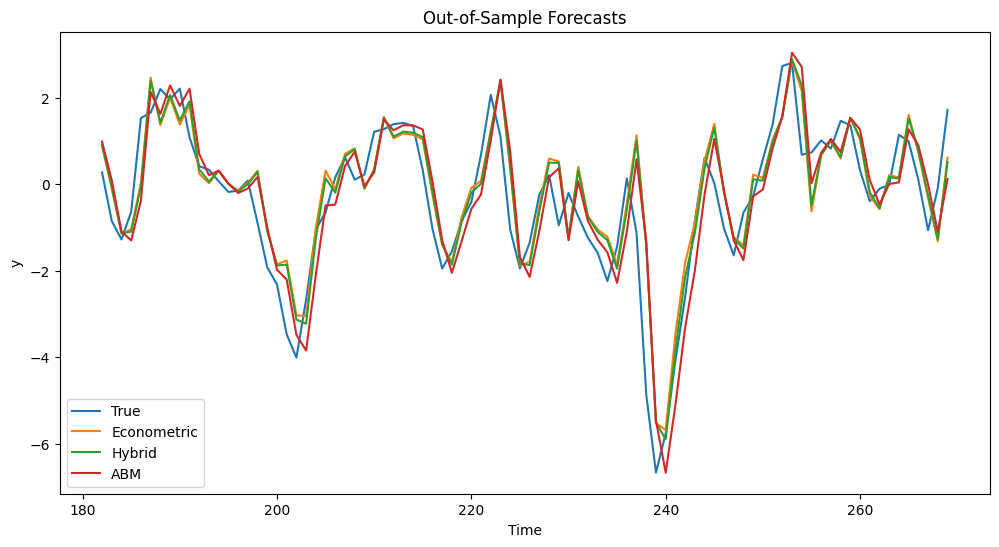

In [35]:
t_out_start = t_end + 1 
y_hat_ectrie, y_hat_adaptive, y_hat_trend, y_hat_anchor, y_hat_abm, y_true_out = forecasts(
    y, t_out_start, t_start, t_end,
    alpha_hat, phi1_hat, phi2_hat,
    theta_hat, gamma_hat, lambda_hat, beta_hat, delta_hat
)
y_hat_hybrid_1 = w_star * y_hat_abm + (1 - w_star) * y_hat_ectrie
plot_out_forecasts(y, t_out_start, y_hat_ectrie, y_hat_adaptive, y_hat_trend, y_hat_anchor, y_hat_abm,y_hat_hybrid_1, y_true_out)

msfe_ectrie = calc_msfe(y_hat_ectrie, y_true_out)
msfe_abm =calc_msfe(y_hat_abm, y_true_out)
msfe_hybrid_1 =calc_msfe(y_hat_hybrid_1, y_true_out)


<div style="text-align:center">
  <h4>Simulation Study </h4>
</div>

In [51]:
def split_crisis_indices(t_out_start, y_true_out, crisis_start, crisis_end):
    time_index = np.arange(t_out_start + 1, t_out_start + 1 + len(y_true_out))
    return (time_index >= crisis_start) & (time_index <= crisis_end)

def calc_msfe_split(y_true, y_pred, is_crisis):
    errors = (y_true - y_pred) ** 2
    msfe_all = np.mean(errors)
    msfe_normal = np.mean(errors[~is_crisis])
    msfe_crisis = np.mean(errors[is_crisis])
    return msfe_all, msfe_normal, msfe_crisis


def run_single_simulation(T=300, crisis_start=230, crisis_end=245, window=10):
    # True DGP
    phi1, phi2 = 1, -0.3
    theta1 = 0.3
    alpha = 0.1
    sigma = 0.6
    alpha_crisis = -0.7
    sigma_crisis = 1

    # Simulate time series
    y = simulate_data(phi1, phi2, theta1, alpha, sigma, alpha_crisis, sigma_crisis, T, crisis_start, crisis_end)

    # Estimation window
    t_start, t_end = 2, 180
    alpha_hat, phi1_hat, phi2_hat = estimate_ar2(y, t_start, t_end)
    theta_hat = estimate_theta_adaptive(y, t_start, t_end)
    gamma_hat = estimate_gamma_trend(y, t_start, t_end)
    lambda_hat = estimate_lambda_anchor(y, t_start, t_end)

    # In-sample ABM forecasts
    bar_y = np.mean(y[t_start - 2:t_end + 1])
    y_hat_adapt, _ = forecast_adaptive(y, t_start, t_end, theta_hat)
    y_hat_trend, _ = forecast_trend(y, t_start, t_end, gamma_hat)
    y_hat_anchor, _ = forecast_anchor(y, t_start, t_end, lambda_hat, bar_y)
    y_insample = y[t_start + 1:t_end + 1]

    res = minimize(objective_beta_delta, x0=[1.0, 0.5],
                   args=(y_insample, y_hat_adapt, y_hat_trend, y_hat_anchor, window),
                   bounds=[(0.01, 500), (0, 1)])
    beta_hat, delta_hat = res.x

    # Forecasts in sample
    y_insample = y[t_start:t_end + 1]
    y_hat_abm, _ = weighted_abm_forecast(y_insample, y_hat_adapt, y_hat_trend, y_hat_anchor, beta_hat, delta_hat, window)
    y_hat_ectrie, _ = forecast_ectrie(y, t_start, t_end, alpha_hat, phi1_hat, phi2_hat)

    # Combine weights
    w_star = calc_weight_forecast_comb(y_insample, y_hat_ectrie, y_hat_abm)
    w_star = np.clip(w_star, 0, 1)
    w_star = 0.5
    y_hat_hybrid_1 = w_star * y_hat_abm + (1 - w_star) * y_hat_ectrie

    # Out-of-sample forecasts
    t_out_start = t_end + 1
    y_hat_ectrie_oos, y_hat_adaptive, y_hat_trend, y_hat_anchor, y_hat_abm_oos, y_true_out = forecasts(
        y, t_out_start, t_start, t_end,
        alpha_hat, phi1_hat, phi2_hat,
        theta_hat, gamma_hat, lambda_hat, beta_hat, delta_hat
    )
    y_hat_hybrid_oos = w_star * y_hat_abm_oos + (1 - w_star) * y_hat_ectrie_oos

    # Regime splitting
    is_crisis = split_crisis_indices(t_out_start, y_true_out, crisis_start, crisis_end)

    # MSFE calculations per model
    msfes_ectrie = calc_msfe_split(y_true_out, y_hat_ectrie_oos, is_crisis)
    msfes_abm = calc_msfe_split(y_true_out, y_hat_abm_oos, is_crisis)
    msfes_hybrid = calc_msfe_split(y_true_out, y_hat_hybrid_oos, is_crisis)

    return (*msfes_ectrie, *msfes_abm, *msfes_hybrid)


def run_simulation_study(n_simulations=100):
    results = []
    attempts = 0
    while len(results) < n_simulations:
        attempts += 1
        try:
            result = run_single_simulation()
            # Check if result is a tuple of finite numbers
            if np.all(np.isfinite(result)):
                results.append(result)
            else:
                #print(f"Attempt {attempts}: discarded result with NaN or inf.")
                print('warning')
        except Exception as e:
            print(f"Attempt {attempts}: simulation failed with error: {e}")
            continue
    return np.array(results)


In [52]:
np.random.seed(99)
run_single_simulation(T=300, crisis_start=230, crisis_end=245, window=10)
results = run_simulation_study(n_simulations=40)
columns = [
"MSFE_Ectrie_All", "MSFE_Ectrie_Normal", "MSFE_Ectrie_Crisis",
"MSFE_ABM_All", "MSFE_ABM_Normal", "MSFE_ABM_Crisis",
"MSFE_Hybrid_All", "MSFE_Hybrid_Normal", "MSFE_Hybrid_Crisis"
]
df = pd.DataFrame(results, columns=columns)
mean_msfe = pd.DataFrame({
    "All": [
        df["MSFE_Ectrie_All"].mean(),
        df["MSFE_ABM_All"].mean(),
        df["MSFE_Hybrid_All"].mean()
    ],
    "Normal": [
        df["MSFE_Ectrie_Normal"].mean(),
        df["MSFE_ABM_Normal"].mean(),
        df["MSFE_Hybrid_Normal"].mean()
    ],
    "Crisis": [
        df["MSFE_Ectrie_Crisis"].mean(),
        df["MSFE_ABM_Crisis"].mean(),
        df["MSFE_Hybrid_Crisis"].mean()
    ]
}, index=["Ectrie", "ABM", "Hybrid"])
mean_msfe.round(4)

C:\Users\yanni\AppData\Local\Temp\ipykernel_16268\710147205.py:74: RuntimeWarning: invalid value encountered in divide
  dc_weights = exp_weights / np.sum(exp_weights)


warning
warning


,All,Normal,Crisis
Ectrie,0.5182,0.3773,1.4160
ABM,0.5680,0.4509,1.3145
Hybrid,0.5082,0.3898,1.2630


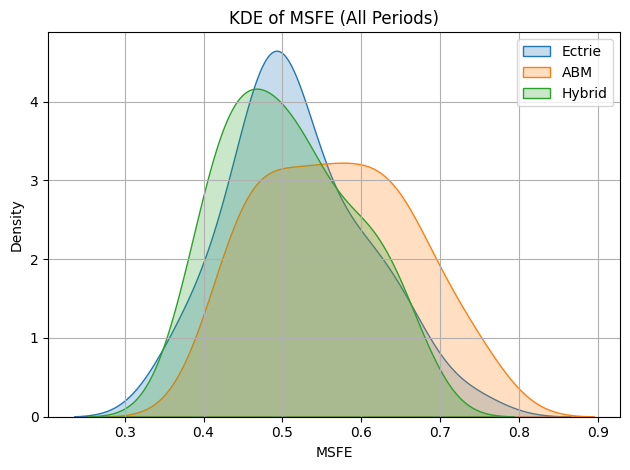

In [53]:
sns.kdeplot(df["MSFE_Ectrie_All"], label="Ectrie", fill=True)
sns.kdeplot(df["MSFE_ABM_All"], label="ABM", fill=True)
sns.kdeplot(df["MSFE_Hybrid_All"], label="Hybrid", fill=True)
plt.title("KDE of MSFE (All Periods)")
plt.xlabel("MSFE")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()